In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchsummary
import torchvision
import torchvision.transforms as transforms

In [3]:
os.chdir('/content/drive/MyDrive/Master Thesis/src')
#from mnist_utils import load_and_transform_mnist, transform_labels_to_binary
from trainers import *
from plots import *

In [4]:
os.chdir('/content/drive/MyDrive/Master Thesis')

MNIST_PATH = '/content/drive/MyDrive/datasets'
RESULTS_PATH = os.path.join(os.path.join(os.getcwd(), "results"), "convnet relu") # unique for each file

In [5]:
class ConvNet(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(4, 2, kernel_size=3, padding=1)
        self.fc = nn.Linear(32, 1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.flatten(start_dim=1)
        out = torch.sigmoid(self.fc(x))
        return out

net = ConvNet()
torchsummary.summary(net, (1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 16, 16]              40
            Conv2d-2              [-1, 2, 8, 8]              74
            Linear-3                    [-1, 1]              33
Total params: 147
Trainable params: 147
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [6]:
keep_classes = [6,8]

criterion = nn.BCELoss()

def get_net():
    net = ConvNet()
    return net

def get_dataset():
    mnist_trainset = torchvision.datasets.MNIST(root=MNIST_PATH, train=True, download=True, transform=transforms.ToTensor())
    mnist_testset = torchvision.datasets.MNIST(root=MNIST_PATH, train=False, download=True, transform=transforms.ToTensor())

    if keep_classes is not None:
        train_mask = [c in keep_classes for c in mnist_trainset.targets]
        mnist_trainset.data = mnist_trainset.data[train_mask]
        mnist_trainset.targets = mnist_trainset.targets[train_mask]

        test_mask = [c in keep_classes for c in mnist_testset.targets]
        mnist_testset.data = mnist_testset.data[test_mask]
        mnist_testset.targets = mnist_testset.targets[test_mask]
        
        class_map = {}
        for i, c in enumerate(keep_classes):
            class_map[c] = i
        
        for i, c in enumerate(mnist_trainset.targets):
            mnist_trainset.targets[i] = class_map[c.item()]
        
        for i, c in enumerate(mnist_testset.targets):
            mnist_testset.targets[i] = class_map[c.item()]

    X_train = mnist_trainset.data.unsqueeze(1).float() / 255.
    y_train = mnist_trainset.targets.unsqueeze(1).float()

    X_test = mnist_testset.data.unsqueeze(1).float() / 255.
    y_test = mnist_testset.targets.unsqueeze(1).float()

    mnist_dataset = {
        "train_data": X_train,
        "train_targets": y_train,
        "test_data": X_test,
        "test_targets": y_test
    }
    
    return mnist_dataset

# Cubic Newton

In [13]:
CN_trainer = {}

for M_min in [1e0]:
    seed = 0
    max_iters = 150
    print_every = 10
    eval_every = 1
    eval_hessian_every = 1
    save_spectrum_every = 5
    save_hessian_every = 10
    save_every = 150
    weight_decay = 0.
    # kwargs
    M = 1.0

    model_dir = os.path.join(os.path.join(RESULTS_PATH, "CN"), f"seed={seed} M_min={M_min}")
    print(f"model_dir: {model_dir}")

    torch.manual_seed(seed)
    CN_trainer[M_min] = AdaptiveCubicNewtonTrainer(get_net(), get_dataset(), criterion, weight_decay, model_dir, M,  M_min)
    CN_trainer[M_min].load()
    print_training_stats(CN_trainer[M_min], print_every)
    #_ = CN_trainer[M_min].train(max_iters, print_every, eval_every, eval_hessian_every, save_spectrum_every, save_hessian_every, save_every)

model_dir: /content/drive/MyDrive/Master Thesis/results/convnet relu/CN/seed=0 M_min=1.0
     0: train loss =  0.693023, test loss =  0.692450, M =   1.00000000, time =    0.00 sec, lambda_n = -0.301670
    10: train loss =  0.044702, test loss =  0.047127, M =   1.00000000, time =  558.22 sec, lambda_n = -0.012152
    20: train loss =  0.025907, test loss =  0.028887, M =   1.00000000, time = 1114.42 sec, lambda_n = -0.002536
    30: train loss =  0.019551, test loss =  0.026426, M =   1.00000000, time = 1668.36 sec, lambda_n = -0.001633
    40: train loss =  0.016414, test loss =  0.026499, M =   1.00000000, time = 2226.97 sec, lambda_n = -0.002057
    50: train loss =  0.014877, test loss =  0.026549, M =   1.00000000, time = 2775.37 sec, lambda_n = -0.002491
    60: train loss =  0.014002, test loss =  0.026274, M =   1.00000000, time = 3326.81 sec, lambda_n = -0.002082
    70: train loss =  0.013350, test loss =  0.025569, M =   1.00000000, time = 3880.62 sec, lambda_n = -0.002486

In [ ]:
print_test_accuracy(CN_trainer[1e0])

Best test accuracy: 99.28%
Last test accuracy: 99.28%


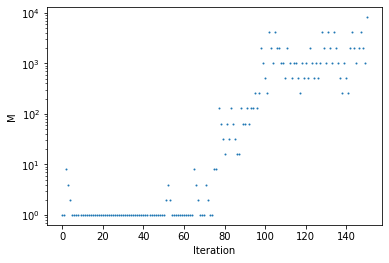

In [ ]:
plot_M(CN_trainer[1e0])

min eigenvalue of (H + Mr/2*I) over all observed iterations:  0.05124871


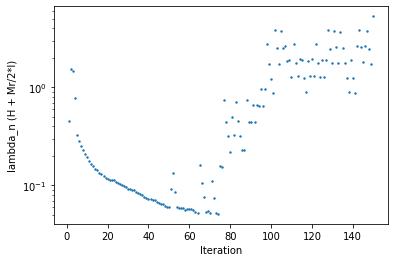

In [ ]:
plot_psd_ness(CN_trainer[1e0])

In [ ]:
visualize_spectrum_evolution(CN_trainer[1e0], plot_every_iter=1, bin_size=0.1, y_range=(0, 150))

In [ ]:
visualize_hessians_evolution(CN_trainer[1e0], plot_every_iter=1)

Output hidden; open in https://colab.research.google.com to view.

# Gradient Descent

In [14]:
seed = 0
max_iters = 4000
print_every = 200
eval_every = 10
eval_hessian_every = 50
save_spectrum_every = 200
save_hessian_every = 500
save_every = 200
weight_decay = 0.
# kwargs
L = 1.0
L_min = 1e-3

model_dir = os.path.join(os.path.join(RESULTS_PATH, "GD"), f"seed={seed} L_min={L_min}")
print(f"model_dir: {model_dir}")

torch.manual_seed(seed)
GD_trainer = AdaptiveGDTrainer(get_net(), get_dataset(), criterion, weight_decay, model_dir, L, L_min)
GD_trainer.load()
print_training_stats(GD_trainer, print_every)
#_ = GD_trainer.train(max_iters, print_every, eval_every, eval_hessian_every, save_spectrum_every, save_hessian_every, save_every)

model_dir: /content/drive/MyDrive/Master Thesis/results/convnet relu/GD/seed=0 L_min=0.001
     0: train loss =  0.693023, test loss =  0.692450, L =   1.00000000, time =    0.00 sec, lambda_n = -0.301670
   200: train loss =  0.035962, test loss =  0.038173, L =   4.00000000, time =  168.98 sec, lambda_n = -0.005618
   400: train loss =  0.027820, test loss =  0.030971, L =   2.00000000, time =  336.00 sec, lambda_n = -0.002738
   600: train loss =  0.023477, test loss =  0.028731, L =   1.00000000, time =  502.47 sec, lambda_n = -0.004614
   800: train loss =  0.020869, test loss =  0.027736, L =   4.00000000, time =  666.27 sec, lambda_n = -0.002159
 1,000: train loss =  0.019095, test loss =  0.027102, L =   8.00000000, time =  836.14 sec, lambda_n = -0.002473
 1,200: train loss =  0.017695, test loss =  0.026291, L =   1.00000000, time = 1002.85 sec, lambda_n = -0.002354
 1,400: train loss =  0.016844, test loss =  0.025949, L =   2.00000000, time = 1168.46 sec, lambda_n = -0.0020

In [ ]:
print_test_accuracy(GD_trainer)

Best test accuracy: 99.48%
Last test accuracy: 99.48%


In [ ]:
visualize_spectrum_evolution(GD_trainer, y_range=(0, 150), bin_size=0.1)

In [ ]:
visualize_hessians_evolution(GD_trainer, plot_every_iter=1)

Output hidden; open in https://colab.research.google.com to view.

# SGD

In [7]:
seed = 0
max_iters = 4000
print_every = 50
eval_every = 10
eval_hessian_every = 50
save_spectrum_every = 200
save_hessian_every = 500
save_every = 200
weight_decay =0.
# kwargs
optim_class = torch.optim.SGD
optim_params = {'lr': 0.1}
dataset = get_dataset()
batch_size = 64

model_dir = os.path.join(os.path.join(RESULTS_PATH, "SGD"), f"seed={seed} lr={optim_params['lr']}, batch_size={batch_size}")
print(f"model_dir: {model_dir}")

torch.manual_seed(seed)
SGD_trainer = CustomTrainer(get_net(), get_dataset(), criterion, weight_decay, model_dir, optim_class, optim_params, batch_size)
SGD_trainer.load()
#print_training_stats(SGD_trainer, print_every)
_ = SGD_trainer.train(max_iters, print_every, eval_every, eval_hessian_every, save_spectrum_every, save_hessian_every, save_every)

model_dir: /content/drive/MyDrive/Master Thesis/results/convnet relu/SGD/seed=0 lr=0.1, batch_size=64
 2,000: train loss =  0.026067, test loss =  0.029931, time =    7.66 sec, lambda_n = -0.007378
 2,050: train loss =  0.027843, test loss =  0.033663, time =    7.89 sec, lambda_n = -0.110626
 2,100: train loss =  0.025580, test loss =  0.030112, time =    8.06 sec, lambda_n = -0.015726
 2,150: train loss =  0.025536, test loss =  0.029947, time =    8.26 sec, lambda_n = -0.028681
 2,200: train loss =  0.025526, test loss =  0.031049, time =    8.41 sec, lambda_n = -0.046645
 2,250: train loss =  0.026675, test loss =  0.029555, time =    8.56 sec, lambda_n = -0.096070
 2,300: train loss =  0.024610, test loss =  0.029271, time =    8.72 sec, lambda_n = -0.002938
 2,350: train loss =  0.026928, test loss =  0.034233, time =    8.87 sec, lambda_n = -0.120088
 2,400: train loss =  0.025957, test loss =  0.029169, time =    9.03 sec, lambda_n = -0.095233
 2,450: train loss =  0.024383, te

In [8]:
print_test_accuracy(SGD_trainer)

Best test accuracy: 99.22%
Last test accuracy: 99.17%


In [9]:
visualize_spectrum_evolution(SGD_trainer, y_range=(0,150), bin_size=0.1)

In [10]:
visualize_hessians_evolution(SGD_trainer, plot_every_iter=1)

Output hidden; open in https://colab.research.google.com to view.

# Plots

In [15]:
metrics = [get_metrics(CN_trainer[1e0]), get_metrics(GD_trainer), get_metrics(SGD_trainer)]
hessian_metrics = [get_hessian_metrics(CN_trainer[1e0]), get_hessian_metrics(GD_trainer), get_hessian_metrics(SGD_trainer)]
labels = ["CN", "GD", "SGD"]

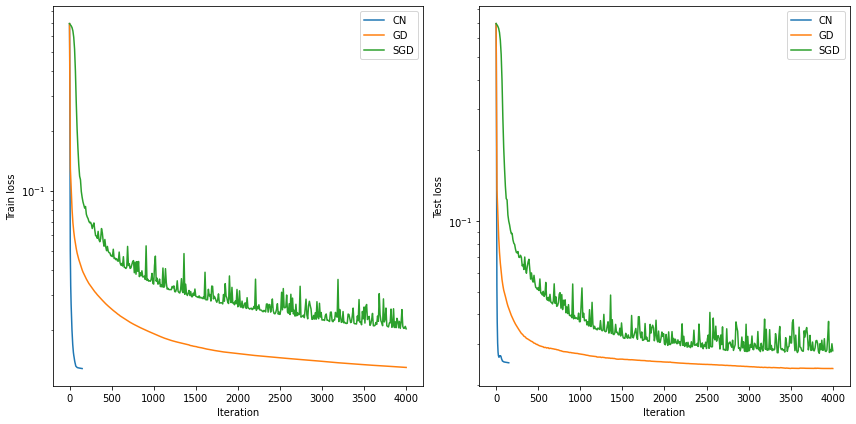

In [16]:
plot_losses(metrics, labels)

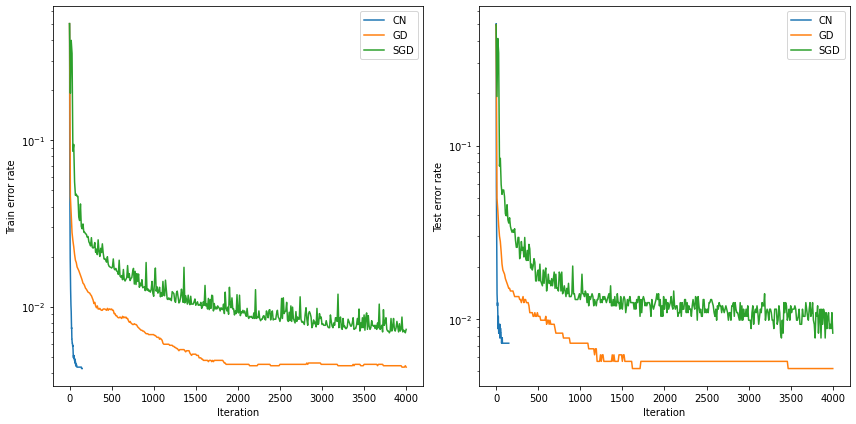

In [17]:
plot_errors(metrics, labels)

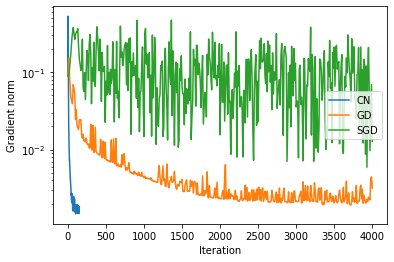

In [18]:
plot_grad_norms(metrics, labels)

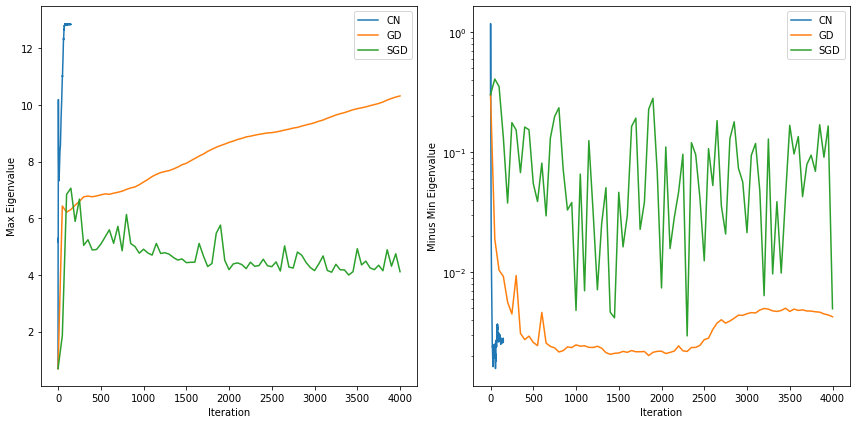

In [19]:
plot_max_min_eigvals(hessian_metrics, labels)

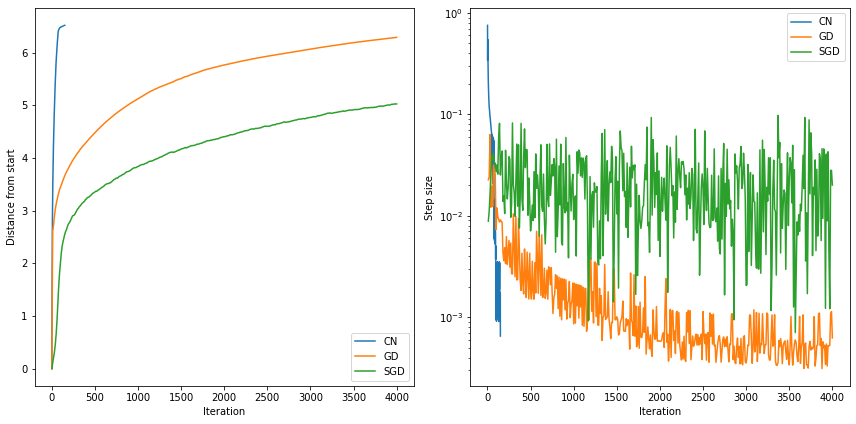

In [20]:
plot_distances(metrics, labels)